# Make Gradient Plots

## Setup

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cnvutils
import matplotlib as mpl
import os

In [2]:
counts = pd.read_csv("cnv_counts.tsv", sep='\t', usecols=['Name', 'Database_ID', 'start_bp', 'end_bp', 'variable', 'value', 'cancer'])

In [3]:
reds = ['#FFFFFF', '#FDF0F0', '#FCE2E2', '#FAD3D3', '#F8C5C5', '#F6B6B6', '#F5A7A7', '#F39999', '#F18A8A', '#EF7B7B', '#EE6D6D', '#EC5E5E', '#EA5050', '#E84141', '#E73232', '#E52424', '#E31515']
blues = ['#FFFFFF', '#F2F0FD', '#E5E0FA', '#D7D1F8', '#CAC2F5', '#BDB2F3', '#B0A3F0', '#A393EE', '#9684EB', '#8875E9', '#7B65E6', '#6E56E4', '#6147E1', '#5437DF', '#4628DC', '#3918DA', '#2C09D7']
gradient = blues[::-1] + reds

## Prepare Table

In [4]:
gain_loss_counts = counts.pivot_table(index=['Name', 'Database_ID', 'cancer'], columns='variable')
gain_loss_counts.columns = gain_loss_counts.columns.to_flat_index()
gain_loss_counts = gain_loss_counts.drop(columns=('start_bp', 'gain'))
gain_loss_counts = gain_loss_counts.drop(columns=('end_bp', 'gain'))
gain_loss_counts = gain_loss_counts.rename(columns = {gain_loss_counts.columns[0]: 'end_bp', gain_loss_counts.columns[1]: 'start_bp', gain_loss_counts.columns[2]: 'gain', gain_loss_counts.columns[3]: 'loss'}, )

In [5]:
gain_loss_counts['length'] = gain_loss_counts.end_bp - gain_loss_counts.start_bp
gain_loss_counts['value'] = gain_loss_counts.gain - gain_loss_counts.loss
gain_loss_counts['bars'] = list(zip(gain_loss_counts.start_bp, gain_loss_counts.length))

## Map Colors

In [23]:
def read_cancer_type_tcga(cancer_type):
    
    df = pd.read_csv(
        os.path.join("..", "data", cancer_type, "Gistic2_CopyNumber_Gistic2_all_thresholded.by_genes.gz"), 
        sep="\t",
        index_col=0
    )
    
    return df

CANCER_TYPES = [ "acc", "blca", "brca", "cesc", "chol", "coad", "coadread", "dlbc", "esca", "gbm", "gbmlgg", 
                "hnsc", "kich", "kirc", "kirp", "laml", "lgg", "lihc", "luad", "lung", "lusc", "meso", "ov", 
                "paad", "pcpg", "prad", "read", "sarc", "skcm", "stad", "tgct", "thca", "thym", "ucec","ucs", 
                "uvm"]

cnv_tables = {}
for cancer_type in CANCER_TYPES:
    cnv_tables[cancer_type] = read_cancer_type_tcga(cancer_type)

In [34]:
cohort_sizes = {}

for cancer in CANCER_TYPES:
    cohort_sizes[str.upper(cancer)] = cnv_tables[cancer].columns.size
    
cohort_sizes = pd.Series(cohort_sizes, name="cohort_size")

In [ ]:
gain_loss_counts = gain_loss_counts.join(cohort_sizes, left on = cancer type)

gain_loss_counts['color'] = gain_loss_counts["value"].apply(map_color)

In [8]:
def map_color(row):
    i = (row["value"] + row["cohort_size"]) // 48
    if i < 0:
        i = 0
    if i > 33:
        i=33
    return gradient[int(i)]

In [8]:
# def map_color(val):
#     i = (val + 819) // 48
#     if i < 0:
#         i = 0
#     if i > 33:
#         i=33
#     return gradient[int(i)]

In [9]:
# def map_reds(val):
#     i = val // 48
#     if i > 16:
#         i = 16
#     return reds[int(i)]

In [10]:
# def map_blues(val):
#     i = val // 48
#     if i > 16:
#         i = 16
#     return blues[int(i)]

In [11]:
# gain_loss_counts['color'] = gain_loss_counts.value.apply(map_color)
# gain_loss_counts['red'] = gain_loss_counts.gain.apply(map_reds)
# gain_loss_counts['blue'] = gain_loss_counts.loss.apply(map_blues)

In [12]:
gain_loss_counts.reset_index(inplace=True)

## Load in cancer driver genes

In [13]:
# This table comes from the article "Comprehensive Characterization of Cancer Driver Genes and Mutations" ([29625053](https://pubmed.ncbi.nlm.nih.gov/29625053/))
# driver_genes = pd.read_csv(
#     os.path.join('bailey_driver_genes.csv'), skiprows=3
# )

In [14]:
# driver_genes = driver_genes.dropna(how="all")
# driver_genes = driver_genes.dropna(how='all', axis=1)

In [15]:
# len(driver_genes.Gene.unique())


## Make the plots

<module 'matplotlib.pyplot' from '/home/caleb/anaconda3/envs/dev/lib/python3.7/site-packages/matplotlib/pyplot.py'>

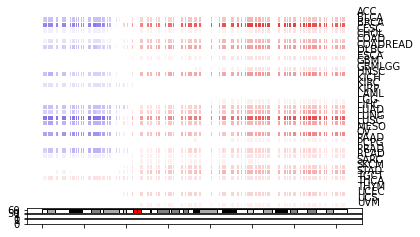

In [16]:
fig, ax = plt.subplots(nrows=len(gain_loss_counts.cancer.unique()) + 4, sharex=True, sharey=False)
count = 0
for cancer in gain_loss_counts.cancer.unique():
    df = gain_loss_counts[gain_loss_counts.cancer == cancer]
    ax[count].broken_barh(df.bars, (0,1), facecolors=df.color)
    ax[count].text(np.max(df.start_bp)+5000000, 0.35, cancer)
    ax[count].set_frame_on(False)
    ax[count].get_xaxis().set_visible(False)
    ax[count].get_yaxis().set_visible(False)
    count += 1
cnvutils.make_chromosome_plot('8', ax=ax[count])

Text(0, 0.5, 'gain - loss')

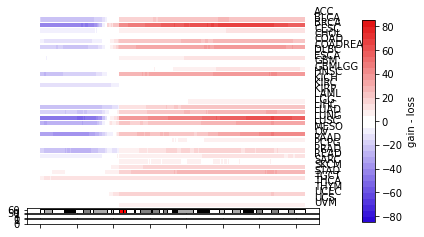

In [17]:
fig, ax = plt.subplots(nrows=len(gain_loss_counts.cancer.unique()) + 4, sharex=True, sharey=False)
count = 0
for cancer in gain_loss_counts.cancer.unique():
    df = gain_loss_counts[gain_loss_counts.cancer == cancer]
    df = df.sort_values('start_bp')
    start_values = df.start_bp
    continuous_values = list()
    prev = 0
    for val in start_values:
        continuous_values.append((prev, val-prev))
        prev = val
    ax[count].broken_barh(continuous_values, (0,1), facecolors=df.color)
    ax[count].text(np.max(start_values)+5000000, 0.35, cancer)
    ax[count].set_frame_on(False)
    ax[count].get_xaxis().set_visible(False)
    ax[count].get_yaxis().set_visible(False)
    count += 1
cnvutils.make_chromosome_plot('8', ax=ax[count], above=False)#, genes=list(driver_genes.Gene.unique()))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
colors = mpl.colors.ListedColormap(gradient)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=-85, vmax=85), cmap=colors), cax=cbar_ax)
cbar.ax.set_ylabel('gain - loss')
# cbar.yaxis.set_

In [18]:
# fig, ax = plt.subplots(nrows=len(gain_loss_counts.cancer.unique()) + 4, sharex=True, sharey=False)
# count = 0
# for cancer in gain_loss_counts.cancer.unique():
#     df = gain_loss_counts[gain_loss_counts.cancer == cancer]
#     df = df.sort_values('start_bp')
#     start_values = df.start_bp
#     continuous_values = list()
#     prev = 0
#     for val in start_values:
#         continuous_values.append((prev, val-prev))
#         prev = val
#     ax[count].broken_barh(continuous_values, (0,1), facecolors=df.red)
#     ax[count].text(np.max(start_values)+5000000, 0.35, cancer)
#     ax[count].set_frame_on(False)
#     ax[count].get_xaxis().set_visible(False)
#     ax[count].get_yaxis().set_visible(False)
#     count += 1
# cnvutils.make_chromosome_plot('8', ax=ax[count])

In [19]:
# fig, ax = plt.subplots(nrows=len(gain_loss_counts.cancer.unique()) + 4, sharex=True, sharey=False)
# count = 0
# for cancer in gain_loss_counts.cancer.unique():
#     df = gain_loss_counts[gain_loss_counts.cancer == cancer]
#     df = df.sort_values('start_bp')
#     start_values = df.start_bp
#     continuous_values = list()
#     prev = 0
#     for val in start_values:
#         continuous_values.append((prev, val-prev))
#         prev = val
#     ax[count].broken_barh(continuous_values, (0,1), facecolors=df.blue)
#     ax[count].text(np.max(start_values)+5000000, 0.35, cancer)
#     ax[count].set_frame_on(False)
#     ax[count].get_xaxis().set_visible(False)
#     ax[count].get_yaxis().set_visible(False)
#     count += 1
# cnvutils.make_chromosome_plot('8', ax=ax[count])